<a href="https://colab.research.google.com/github/GabrielCostaDeOliveira/faceDetectionTraining/blob/main/faceDetectionDL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

from fastai.vision.all import *
import numpy as np

Definindo o `path` para o dataset.

In [2]:
path = Path(os.path.join(os.getcwd(), '..', 'dataset')) # Pega o path onde o python será executado, volta e seleciona o dataset
Path.BASE_PATH = path # Muda a raiz do path para o dataset
path.ls()

(#3) [Path('wider_face_split'),Path('WIDER_train'),Path('WIDER_val')]

Verificando se as imagens não foram corrompidas

In [3]:
images = get_image_files(path) # retorna todos os caminho de imagens
failed = verify_images(images) # retorna os caminho para imagens com falhas
failed

Eliminando as imagens que falharam

In [4]:
failed.map(Path.unlink) # Para cada caminho, exclui o arquivo associado

(#0) []

Definindo funções auxiliares para recuperar as anotações das imagens dado seu _path_
Variáveis dependentes dos dados

In [4]:
# Retorna o caminho dentro da pasta annotations para as anotações de cada imagem
# caminho retira o formato da imagem (.jpg)
#
#
# Ex de path:
# /home/adriansl/unb/2022_1/ml/faceDetectionTraining/dataset/WIDER_val/images/0--Parade/0_Parade_marchingband_1_20.jpg
# split = [
#   '/home/adriansl/unb/2022_1/ml/faceDetectionTraining/dataset/WIDER_val/',
#   '/0--Parade/0_Parade_marchingband_1_20.jpg'
# ]
def img2bbox_path(path: Path):
    return 'annotations'.join(str(path).rsplit('images', 1))[:-4] # split pela direita

# Retorna um array numpy com n linhas dos dados de cada rosto
# [`left`, `top`, `width`, `height`].
# lê os dados dos arquivos annotations gerados pelo script 
# create_annotations.py (executado antes do notebook)
def get_annotation_values(path: Path):
    # with lida com tratamento de exceções e garbage collection
    # de forma padronizada pelo próprio objeto
    # Utiliza fases de execuçaçao
    with open(img2bbox_path(path), 'r', encoding='utf-8') as f:
        # para cada linha do annotation daquela imagem, 
        # cria uma lista com os dados
        #
        # faz split de cada inteiro da linha
        # operador * faz o spreading (separação) dos itens do map
        return np.array([[*map(int, s.split())] for s in f.readlines()])

## Função para recuperar a bounding box de uma imagem dado seu caminho
**Recupera** somente os 4 primeiros valores (bounding box )
**[`left`, `top`, `width`, `height`].**

In [9]:
def get_bbox(path):
    ctr = get_annotation_values(path)
    if ctr.any():
        return ctr[:,:4]
    return []

Visualizando um exemplo de imagem com sua bounding box

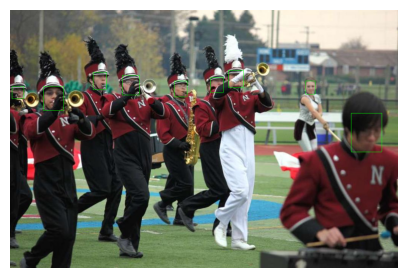

In [13]:
img = plt.imread(images[0]).copy()
for x,y,w,h in get_bbox(images[0]):
    color = np.array([0,255,0], dtype=np.uint8)
    img[y,x:x+w] = color
    img[y:y+h,x] = color
    img[y+h,x:x+w] = color
    img[y:y+h,x+w] = color
show_image(img);

A fastai espera a bounding box no formato [`left`, `top`, `right`, `bottom`].

Porém o nosso dataset utiliza no formato [`left`, `top`, `width`, `height`].

Então precisamos converter a bounding box para o formato da fastai. Para isso vamos alterar a função `get_bbox` definida anteriormente.

In [15]:
def get_bbox(path):
    ctr = get_annotation_values(path)
    if ctr.any():
        return [[x, y, x + w - 1, y + h - 1] for x, y, w, h in ctr[:,:4]]
    return []

apresentando a mesma imagem com o novo formato da bounding box

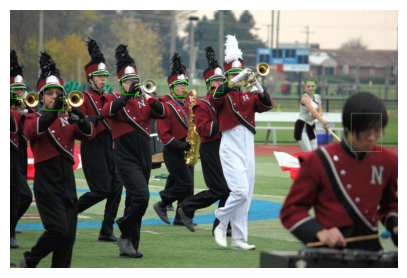

In [16]:
img = plt.imread(images[0]).copy()
for x1,y1,x2,y2 in get_bbox(images[0]):
    color = np.array([0,255,0], dtype=np.uint8)
    img[y1,x1:x2] = color
    img[y1:y2,x1] = color
    img[y2,x1:x2] = color
    img[y1:y2,x2] = color
show_image(img);

Função para recuperar os labels de uma imagem dado seu _path_
Label além do boundind box, verifica se a face tem algum tipo de obstrução.

In [67]:
def get_label(path, lbl=['no occlusion', 'partial occlusion', 'heavy occlusion']):
    ctr = get_annotation_values(path)
    if ctr.any():
        return [lbl[x] for x in ctr[:,-2]]
    return []

In [68]:
data_block = DataBlock(
    blocks=(ImageBlock, BBoxBlock, BBoxLblBlock),
    get_items=get_image_files,
    # noop == no-operation, já que ImageBlock já retorna a imagem do caminho para o batch
    # utilizanfo PILBase.create
    # funcções separadas para as variáveis dependentes do BBox e para as labels
    getters=[noop, get_bbox, get_label],
    # Como o dado já está separado em validação, a função verifica se 
    # o caminho ../../../nome_da_pasta termina com 'val':
    splitter=FuncSplitter(lambda o: o.parent.parent.parent.name.endswith('val')),
    item_tfms=Resize(256, method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
    # batch_tfms=[*aug_transforms(min_scale=1.0), Normalize.from_stats(*imagenet_stats)],
    n_inp=1
)
# Testes iniciais com o datablock
data_block.summary(path)

Setting-up type transforms pipelines
Found 16106 items
2 datasets of sizes 12880,3226
Setting up Pipeline: PILBase.create
Setting up Pipeline: get_bbox -> TensorBBox.create
Setting up Pipeline: get_label -> MultiCategorize -- {'vocab': None, 'sort': True, 'add_na': True}

Building one sample
  Pipeline: PILBase.create
    starting from
      c:\Users\Thalisson\prog\aulas\ml\faceDetectionTraining\src\..\dataset\WIDER_train\images\0--Parade\0_Parade_marchingband_1_100.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=1024x682
  Pipeline: get_bbox -> TensorBBox.create
    starting from
      c:\Users\Thalisson\prog\aulas\ml\faceDetectionTraining\src\..\dataset\WIDER_train\images\0--Parade\0_Parade_marchingband_1_100.jpg
    applying get_bbox gives
      [[433, 189, 466, 230], [88, 203, 140, 266], [5, 203, 35, 235], [296, 174, 340, 225], [219, 166, 253, 211], [900, 274, 980, 375], [780, 189, 804, 223], [576, 161, 615, 205], [529, 180, 562, 219]]
    applying TensorBBox.cre

Como podemos ver, nosso dataset é possui `12880` itens para treino e `3226` para validação.

In [69]:
datasets = data_block.datasets(path)

len(datasets.train), len(datasets.valid)

(12880, 3226)

Onde cada item é composto por uma imagem (a variável independente), uma tensor de bounding boxes e um tensor de multi categorias (que juntos compõem as variáveis dependentes).

In [54]:
datasets.train[0]

(PILImage mode=RGB size=1024x682,
 TensorBBox([[433., 189., 466., 230.],
             [ 88., 203., 140., 266.],
             [  5., 203.,  35., 235.],
             [296., 174., 340., 225.],
             [219., 166., 253., 211.],
             [900., 274., 980., 375.],
             [780., 189., 804., 223.],
             [576., 161., 615., 205.],
             [529., 180., 562., 219.]]),
 TensorMultiCategory([2, 1, 3, 1, 2, 2, 2, 1, 1]))

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


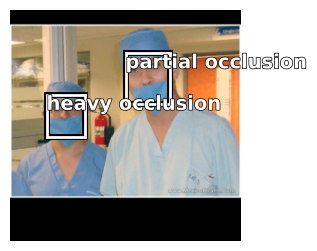

In [76]:
data_loaders = data_block.dataloaders(path, bs=6)
data_loaders.train.show_batch(max_n=1)